# MACD

在MACD_3的基础上加入仓位风险控制模块，提高收益稳定性。最终实现Sharpe Ratio：？，总收益率：？，百分比最大回撤: ？

## 配置引擎参数

In [235]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [236]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 100             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-5]-MACD[-6])/MACD[-6]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.25) and (diff_MACD_2>0.1) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.25) and (diff_MACD_2<-0.1) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [237]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x000001B2730E89D8>, <__main__.MACDStrategy object at 0x000001B21E0569B0>)
2018-12-19 21:51:25.722196	开始回测
2018-12-19 21:51:25.722196	策略初始化
2018-12-19 21:51:25.723192	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-19 21:51:26.289687	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 21:51:26.295692	载入完成，数据量：12000
2018-12-19 21:51:26.297665	策略初始化完成
2018-12-19 21:51:26.297665	策略启动完成
2018-12-19 21:51:26.297665	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 21:51:26.327577	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 21:51:38.095641	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 21:51:38.151491	载入完成，数据量：257407
2018-12-19 21:51:38.151491	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-19 21:51:38.153484	载入历史数据。数据范围:[20180531 08:51,20180603 00:01

In [238]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-05 06:00:00,空,,,0.0,,开仓,1,,7547.84,0.0,None,,,1,2018-06-05 06:00:00,100,1,BTCUSDT:binance,1
2018-06-26 22:00:00,多,,,0.0,,平仓,2,,6170.03,0.0,None,,,2,2018-06-26 22:00:00,100,2,BTCUSDT:binance,2
2018-06-26 22:00:00,多,,,0.0,,开仓,3,,6170.03,0.0,None,,,3,2018-06-26 22:00:00,100,3,BTCUSDT:binance,3
2018-06-28 16:00:00,空,,,0.0,,平仓,4,,6116.75,0.0,None,,,4,2018-06-28 16:00:00,100,4,BTCUSDT:binance,4
2018-06-28 16:00:00,空,,,0.0,,开仓,5,,6116.75,0.0,None,,,5,2018-06-28 16:00:00,100,5,BTCUSDT:binance,5
2018-06-30 10:00:00,多,,,0.0,,平仓,6,,6411.99,0.0,None,,,6,2018-06-30 10:00:00,100,6,BTCUSDT:binance,6
2018-06-30 10:00:00,多,,,0.0,,开仓,7,,6411.99,0.0,None,,,7,2018-06-30 10:00:00,100,7,BTCUSDT:binance,7
2018-07-11 04:00:00,空,,,0.0,,平仓,8,,6376.13,0.0,None,,,8,2018-07-11 04:00:00,100,8,BTCUSDT:binance,8
2018-07-11 04:00:00,空,,,0.0,,开仓,9,,6376.13,0.0,None,,,9,2018-07-11 04:00:00,100,9,BTCUSDT:binance,9


## 查看绩效回测绩效

2018-12-19 21:51:52.521602	计算按日统计结果
2018-12-19 21:51:52.568475	------------------------------
2018-12-19 21:51:52.568475	首个交易日：	2018-06-01 00:00:00
2018-12-19 21:51:52.568475	最后交易日：	2018-11-27 00:00:00
2018-12-19 21:51:52.568475	总交易日：	180
2018-12-19 21:51:52.568475	盈利交易日	104
2018-12-19 21:51:52.568475	亏损交易日：	71
2018-12-19 21:51:52.568475	起始资金：	1000000
2018-12-19 21:51:52.568475	结束资金：	1,542,338.11
2018-12-19 21:51:52.568475	总收益率：	54.23%
2018-12-19 21:51:52.568475	年化收益：	72.31%
2018-12-19 21:51:52.568475	总盈亏：	542,338.11
2018-12-19 21:51:52.568475	最大回撤: 	-103,648.14
2018-12-19 21:51:52.568475	百分比最大回撤: -7.39%
2018-12-19 21:51:52.569472	总手续费：	17,429.29
2018-12-19 21:51:52.569472	总滑点：	10.6
2018-12-19 21:51:52.569472	总成交金额：	34,858,580.0
2018-12-19 21:51:52.569472	总成交笔数：	53
2018-12-19 21:51:52.569472	日均盈亏：	3,012.99
2018-12-19 21:51:52.569472	日均手续费：	96.83
2018-12-19 21:51:52.569472	日均滑点：	0.06
2018-12-19 21:51:52.569472	日均成交金额：	193,658.78
2018-12-19 21:51:52.569472	日均成交笔数：	0.29
2018-12-19 21:51:5

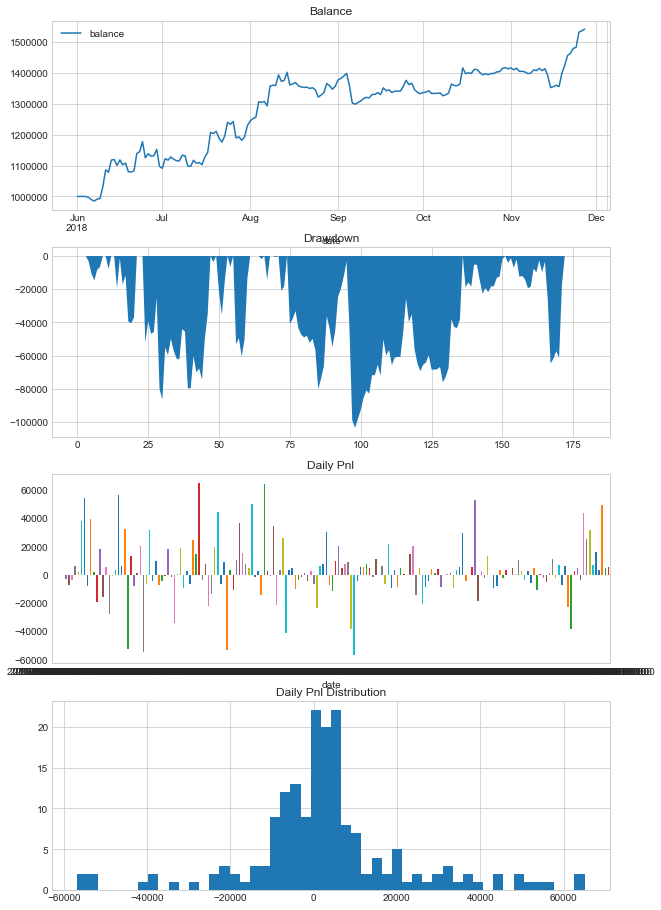

In [239]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-19 21:51:55.076982	计算回测结果
2018-12-19 21:51:55.079975	------------------------------
2018-12-19 21:51:55.079975	第一笔交易：	2018-06-26 22:00:00
2018-12-19 21:51:55.081969	最后一笔交易：	2018-11-27 23:57:00
2018-12-19 21:51:55.082965	总交易次数：	27
2018-12-19 21:51:55.082965	总盈亏：	542,148.86
2018-12-19 21:51:55.082965	最大回撤: 	-78,819.27
2018-12-19 21:51:55.082965	平均每笔盈利：	20,079.59
2018-12-19 21:51:55.082965	平均每笔滑点：	0.4
2018-12-19 21:51:55.082965	平均每笔佣金：	652.53
2018-12-19 21:51:55.082965	胜率		55.56%
2018-12-19 21:51:55.082965	盈利交易平均值	51,539.04
2018-12-19 21:51:55.082965	亏损交易平均值	-19,244.72
2018-12-19 21:51:55.082965	盈亏比：	2.68


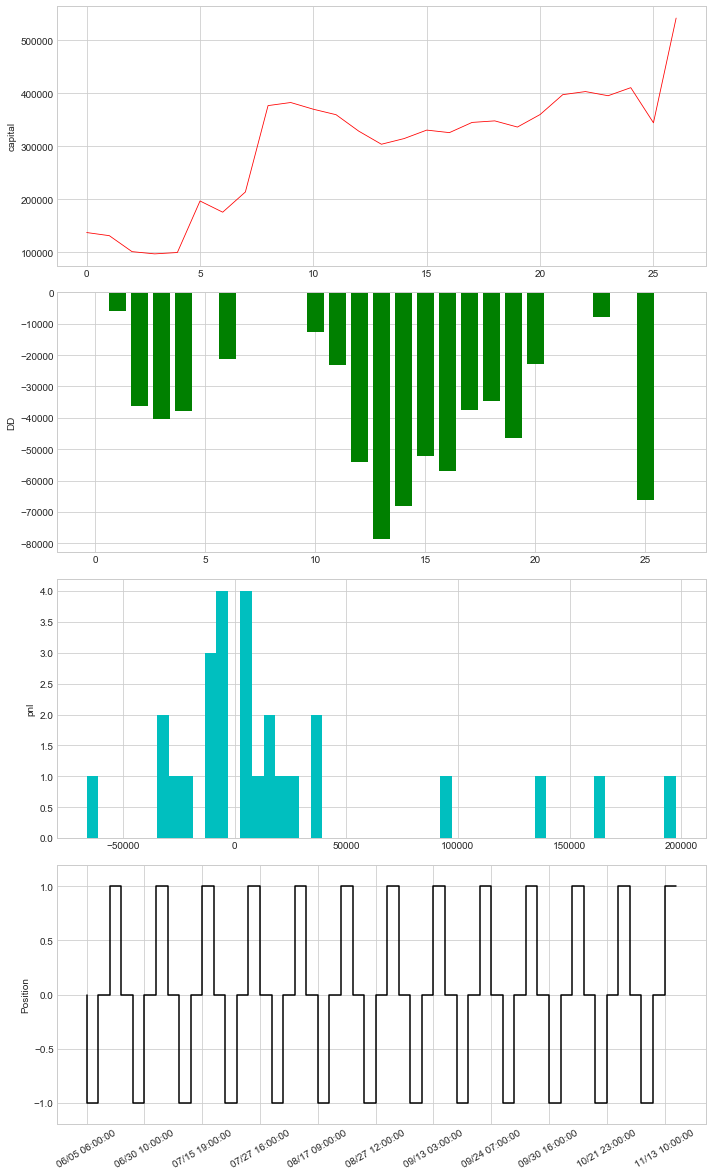

In [240]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [241]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-19 21:51:55.629365	计算按日统计结果


In [242]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           180
profitDays                          104
lossDays                             71
endBalance                  1.54234e+06
maxDrawdown                     -103648
maxDdPercent                   -7.39049
totalNetPnl                      542338
dailyNetPnl                     3012.99
totalCommission                 17429.3
dailyCommission                 96.8294
totalSlippage                      10.6
dailySlippage                 0.0588889
totalTurnover               3.48586e+07
dailyTurnover                    193659
totalTradeCount                      53
dailyTradeCount                0.294444
totalReturn                     54.2338
annualizedReturn                72.3117
dailyReturn                    0.240722
returnStd                       1.57525
sharpeRatio                      2.3674
dtype: object


下面对EOS品种进行检测
对策略做了参数调整：
1）手数改为10000
2）diff_MACD_2的周期，还有阈值。

In [243]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180611 00:00',initHours=20) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [292]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 10000             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-3]-MACD[-4])/MACD[-4]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.25) and (diff_MACD_2>0) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.25) and (diff_MACD_2<0) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [293]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x000001B20C9EB378>, <__main__.MACDStrategy object at 0x000001B212123E10>)
2018-12-19 21:59:58.739541	开始回测
2018-12-19 21:59:58.739541	策略初始化
2018-12-19 21:59:58.739541	载入历史数据。数据范围:[20180610 04:00,20180611 00:00)
2018-12-19 21:59:58.823462	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 21:59:58.823462	载入完成，数据量：1200
2018-12-19 21:59:58.824423	策略初始化完成
2018-12-19 21:59:58.824423	策略启动完成
2018-12-19 21:59:58.824423	开始回放回测数据,回测范围:[20180611 00:00,20181127 23:59)
2018-12-19 21:59:58.844403	载入历史数据。数据范围:[20180611 00:00,20181127 23:59)
2018-12-19 22:00:11.116737	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 22:00:11.179571	载入完成，数据量：243007
2018-12-19 22:00:11.180567	当前回放数据:[20180611 00:00,20181127 23:59)
[INFO] 品种EOSUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180611000000
2018-12-19 22:00:11.184570	载入历史数据。数据范围:[20180610 08:51,20180613 00:01)

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606200000 , 20180610230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180611000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180611000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.15, 'high': 13.1647, 'low': 12.922, 'close': 12.9499, 'date': '20180611', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 11, 0, 0), 'volume': 385852.4499999997, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606210000 , 20180611000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180611000000
2018-12-19 22:00:22.237893	数据回放结束ss: 100%    


In [294]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-11 11:00:00,空,,,0.0,,开仓,1,,11.5498,0.0,None,,,1,2018-06-11 11:00:00,10000,1,EOSUSDT:binance,1
2018-06-19 02:00:00,多,,,0.0,,平仓,2,,10.6808,0.0,None,,,2,2018-06-19 02:00:00,10000,2,EOSUSDT:binance,2
2018-06-19 02:00:00,多,,,0.0,,开仓,3,,10.6808,0.0,None,,,3,2018-06-19 02:00:00,10000,3,EOSUSDT:binance,3
2018-06-21 07:00:00,空,,,0.0,,平仓,4,,10.4072,0.0,None,,,4,2018-06-21 07:00:00,10000,4,EOSUSDT:binance,4
2018-06-21 07:00:00,空,,,0.0,,开仓,5,,10.4072,0.0,None,,,5,2018-06-21 07:00:00,10000,5,EOSUSDT:binance,5
2018-06-21 22:00:00,多,,,0.0,,平仓,6,,10.3939,0.0,None,,,6,2018-06-21 22:00:00,10000,6,EOSUSDT:binance,6
2018-06-21 22:00:00,多,,,0.0,,开仓,7,,10.3939,0.0,None,,,7,2018-06-21 22:00:00,10000,7,EOSUSDT:binance,7
2018-06-22 09:00:00,空,,,0.0,,平仓,8,,10.3916,0.0,None,,,8,2018-06-22 09:00:00,10000,8,EOSUSDT:binance,8
2018-06-22 09:00:00,空,,,0.0,,开仓,9,,10.3916,0.0,None,,,9,2018-06-22 09:00:00,10000,9,EOSUSDT:binance,9


2018-12-19 22:00:22.315687	计算按日统计结果
2018-12-19 22:00:22.350593	------------------------------
2018-12-19 22:00:22.350593	首个交易日：	2018-06-11 00:00:00
2018-12-19 22:00:22.350593	最后交易日：	2018-11-27 00:00:00
2018-12-19 22:00:22.350593	总交易日：	170
2018-12-19 22:00:22.350593	盈利交易日	88
2018-12-19 22:00:22.350593	亏损交易日：	81
2018-12-19 22:00:22.350593	起始资金：	1000000
2018-12-19 22:00:22.351590	结束资金：	1,088,061.82
2018-12-19 22:00:22.351590	总收益率：	8.81%
2018-12-19 22:00:22.351590	年化收益：	12.43%
2018-12-19 22:00:22.351590	总盈亏：	88,061.82
2018-12-19 22:00:22.351590	最大回撤: 	-32,047.93
2018-12-19 22:00:22.351590	百分比最大回撤: -2.98%
2018-12-19 22:00:22.351590	总手续费：	3,056.18
2018-12-19 22:00:22.351590	总滑点：	1,860.0
2018-12-19 22:00:22.351590	总成交金额：	6,112,350.0
2018-12-19 22:00:22.351590	总成交笔数：	93
2018-12-19 22:00:22.351590	日均盈亏：	518.01
2018-12-19 22:00:22.351590	日均手续费：	17.98
2018-12-19 22:00:22.351590	日均滑点：	10.94
2018-12-19 22:00:22.351590	日均成交金额：	35,955.0
2018-12-19 22:00:22.351590	日均成交笔数：	0.55
2018-12-19 22:00:22.3515

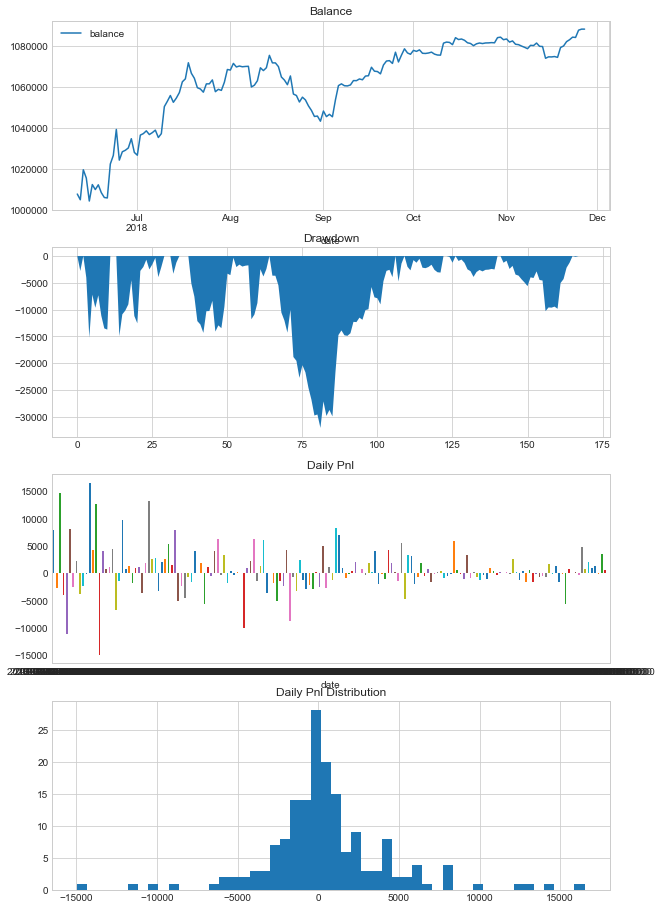

In [295]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-19 22:00:24.431152	计算回测结果
2018-12-19 22:00:24.436137	------------------------------
2018-12-19 22:00:24.436137	第一笔交易：	2018-06-19 02:00:00
2018-12-19 22:00:24.436137	最后一笔交易：	2018-11-27 23:57:00
2018-12-19 22:00:24.436137	总交易次数：	47
2018-12-19 22:00:24.436137	总盈亏：	90,882.03
2018-12-19 22:00:24.436137	最大回撤: 	-27,575.54
2018-12-19 22:00:24.436137	平均每笔盈利：	1,933.66
2018-12-19 22:00:24.436137	平均每笔滑点：	40.0
2018-12-19 22:00:24.436137	平均每笔佣金：	65.34
2018-12-19 22:00:24.436137	胜率		46.81%
2018-12-19 22:00:24.436137	盈利交易平均值	6,786.74
2018-12-19 22:00:24.437135	亏损交易平均值	-2,337.05
2018-12-19 22:00:24.437135	盈亏比：	2.9


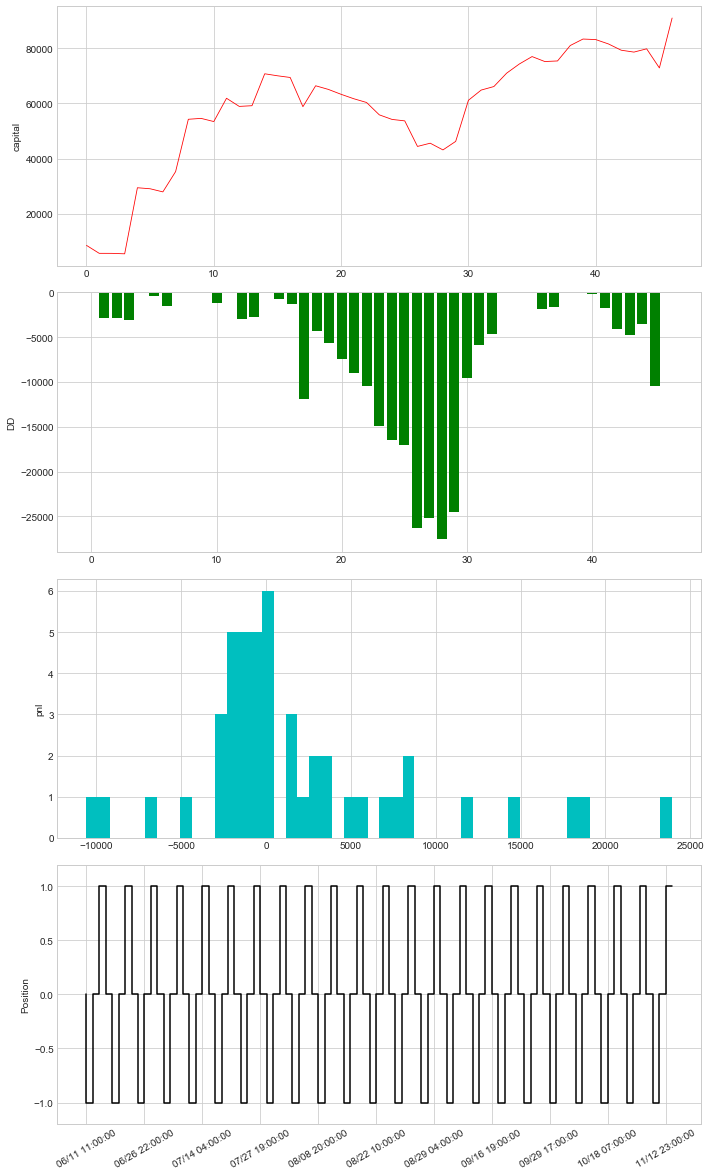

In [296]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [297]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           180
profitDays                          104
lossDays                             71
endBalance                  1.54234e+06
maxDrawdown                     -103648
maxDdPercent                   -7.39049
totalNetPnl                      542338
dailyNetPnl                     3012.99
totalCommission                 17429.3
dailyCommission                 96.8294
totalSlippage                      10.6
dailySlippage                 0.0588889
totalTurnover               3.48586e+07
dailyTurnover                    193659
totalTradeCount                      53
dailyTradeCount                0.294444
totalReturn                     54.2338
annualizedReturn                72.3117
dailyReturn                    0.240722
returnStd                       1.57525
sharpeRatio                      2.3674
dtype: object
